# These are the same tools as in the Follow Up Analysis example, just rearranged for ease of use

In [102]:
#Constants
#for reporting TLS model's planet radius
R_earth = 6.378*10.0**8.0 #cm
R_sun = 6.955*10.0**10.0 #cm

#modules
import lightkurve as lk


import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch

#Needed for making plots
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec

#Needed for handling lists, arrays, strings, importing data and general math
import numpy as np
# import pandas as pd #optional (may be used in future)

#Needed for r
import astropy
from astropy.stats import BoxLeastSquares # <--- Super Important! We use this to search for periodic events in our data.
# print(astropy.__version__)


from transitleastsquares import catalog_info
from transitleastsquares import period_grid
from transitleastsquares import transitleastsquares

import warnings
# warnings.filterwarnings(action='once') #useful to see a warning once but that's it
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses


import wotan
from wotan import flatten


from astroML.time_series import lomb_scargle

def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
#     print ("criterion: ", criterion)
#     print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)


#-========= Karen's inverse weighted binning function ++++
def Bin_func(time,flux,error,binsize):
    good = np.where(np.isfinite(time))
    timefit = time[good]
    fluxfit = flux[good]
    errfit  = error[good]
    timemax = np.max(timefit)
    timemin = np.min(timefit)
    npoints = len(timefit)
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days
    bintime = np.full((nbins,), np.nan)
    binflux = np.full((nbins,), np.nan)
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )]
        if tobin[0] != -1:
    #     inverse variance weighted means
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime))
    bintime = bintime[good2]
    binflux = binflux[good2]
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr

In [103]:
# Extra custom definitions for detrending

# Change these parameters around to refine the detrending process

def momentumdump_removal(SectorNum,before_after_in_minutes, time, flux, flux_error):
#     print("before: ",len(time),len(flux),len(flux_error))
    if SectorNum==1:
        jittermask = (time < 1346) | (time > 1350)
        mdumps=2.5

        t2,f2,fe2=time[jittermask], flux[jittermask], flux_error[jittermask]

    elif SectorNum==3:
        jittermask = (time < 1382.6) | (time > 1383.65)
        mdumps=3.125

        t2,f2,fe2=time[jittermask], flux[jittermask], flux_error[jittermask]

    if SectorNum==2:
        mdumps=2.5
        t2,f2,fe2=time,flux,flux_error  #I haven't yet identified bad regions of data for Sector 2
        
    Num_mdumps = int(np.round((t2[-1]-t2[0])/mdumps,2))
    before_after = before_after_in_minutes/(60.0*24.0) # in days
    
    tt,ff,fefe = t2,f2,fe2
    
    for N in range(Num_mdumps):
        time_mdump = tt[0]+N*mdumps
        minus = time_mdump - before_after
        plus  = time_mdump + before_after
        mask_mdump = (tt < minus) | (tt > plus)
        
        tt,ff,fefe = tt[mask_mdump], ff[mask_mdump], fefe[mask_mdump]
        
    print("N pts before: ",len(time)," N pts after: ", len(tt))
    return tt,ff,fefe
        
        

# removing regions of bad data by visually identifying a range of data
def remove_bad_data(time,flux,flux_error, badtime1, badtime2):
    bad_data_mask = (time < badtime1) | (time > badtime2)
    
    return time[bad_data_mask], flux[bad_data_mask], flux_error[bad_data_mask]

# Filters

#BiWeighted MidCorrelation robust filter
def BWMC(window_size_in_hrs,time,flux,flux_error): #bt = break tolerance, pipeline uses window_size/2.0
    
    window_size = window_size_in_hrs/24.0 # The length of the filter window in units of time (days)
    flatten_lc, trend_lc = flatten(time, flux, window_length=window_size, return_trend=True, break_tolerance=window_size/2.0,method='biweight',robust=True)
    T=time
    F=flatten_lc
    FE=flux_error

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]
    
    T,F,FE = ChauventsCriteron(T,F,FE)

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]
    
    return T,F,FE
  
#Quasi-Periodic Gaussian Process Detrending
def GP(length_scale,time,flux,flux_error):
    length_scale=length_scale # 1 to 2 is generally pretty good from my tests
    gpflatten_lc, gptrend_lc = flatten(time,flux,method='gp', \
                                         kernel='periodic_auto',kernel_size=length_scale,return_trend=True,robust=True)

    T=time
    F= gpflatten_lc
    FE = flux_error

    nanmask = np.where(np.isfinite(gpflatten_lc)==True)[0]
    T = T[nanmask]
    F = gpflatten_lc[nanmask]/np.mean(gpflatten_lc[nanmask])
    FE =FE[nanmask]
    
    T,F,FE = ChauventsCriteron(T,F,FE)

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]
    
    return T,F,FE
    
#Savitsky-Golay Filter
def SG(time,flux,flux_error,window_size_in_hrs,poly_order): #polynomial order is 3 in our pipeline
    cad = time[1]-time[0]
    
    #now let's define a window size to smooth our data with:
    window_size = int(window_size_in_hrs/cad) #number of data points in N hour window
    if (window_size % 2) == 0: #must be odd. If not, there will be an error
        window_size = window_size+1
    flatten_lc, trend_lc = flatten(time,flux,method='savgol',window_length=window_size,cval=poly_order,return_trend=True)


    nanmask = np.where(np.isfinite(flatten_lc)==True)[0]
    T = time[nanmask]
    F = flatten_lc[nanmask]/np.mean(flatten_lc[nanmask])
    FE =flux_error[nanmask]
    
    T,F,FE = ChauventsCriteron(T,F,FE)

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]
    
    return T,F,FE



# Input=input("What Detrending Method would you like to use? (BWMC, GP, SG) ")
def Detrending_Method(time,flux,error,Input=None):
    
    SectorNum=float(input("Sector Number? (1,2,3,4,5) Answer: "))
    before_after_in_minutes = float(input("How much data to remove before/after momentum dumps? (in minutes) Answer: "))
    time,flux,error = momentumdump_removal(SectorNum,before_after_in_minutes, time,flux,error)
    
    
    
    Input=input("What Detrending Method would you like to use? (BWMC, GP, SG)  Answer: ")
    if Input =="BWMC":
        window=float(input("BWMC window size (in hours)? (5 is default in pipeline)  Answer: "))
        T,F,E = BWMC(window,time,flux,error)
#         print('a')
        
    elif Input == "GP":
        length_scale=float(input("GP length scale? (2 is default in pipeline)  Answer: "))
        T,F,E = GP(length_scale,time,flux,error)
#         print('b')
        
    if Input == "SG":
        window_size_in_hrs=float(input("SG window size (in hours) (5 matches to pipeline)?  Answer: "))
        cad = time[1]-time[0] #cadence of data sampling
        window_size = int(window_size_in_hrs/cad) #number of data points in N hour window
        if (window_size % 2) == 0: #must be odd. If not, there will be an error
            window_size = window_size+1
#         print('c')  
        poly_order = float(input("Polynomial Order? (3 is default)  Answer: "))
        T,F,E = SG(time,flux,error,window_size_in_hrs,poly_order)

    return T,F,E

In [104]:
# Extra custom functions for TLS
def phasefold(T0,time,period):
    return (time- T0 + 0.5*period) % period - 0.5*period        
    


def TLS_func(ID,time,flux,error,minP,minDur,maxDur,N_transits):

    
    qld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)


    maxP= (max(time)-min(time)) #length of our light curve

    #creating list of orbital periods to model with
    periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP/3.0)#,oversampling_factor=10)

    durations = np.linspace(minDur,maxDur,25)

    tls = transitleastsquares(time,flux,error)
    tls_power = tls.power(R_star=R_star,period_min=minP,period_max=maxP,show_progress_bar=False,n_transits_min=N_transits,duration_grid_step=1.02)
    tls_power_periods = tls_power.periods
    
    #TLS results
    TLS_periods=tls_power.period
    TLS_t0s=tls_power.T0
    TLS_depths=tls_power.depth
    TLS_SDE=tls_power.power
    TLS_Dur = tls_power.duration
    TLS_TCs = tls_power.transit_times

    #calculating TLS estimated planet radius
    R_p = np.sqrt(1.0-TLS_depths)*R_star*R_sun/R_earth
    
    TLS_model_time = tls_power.model_lightcurve_time 
    TLS_model = tls_power.model_lightcurve_model 
    return tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_SDE, TLS_Dur,TLS_TCs, R_p, TLS_model_time, TLS_model, R_star, M_star

def TLS_plot(time,flux,error, tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_Dur, R_p, TLS_model_time, TLS_model,window_size,R_star,M_star,mdumps):
    
    fs = 9
    spacing = 0.02
    #for reporting TLS model's planet radius
    R_earth = 6.378*10.0**8.0 #cm
    R_sun = 6.955*10.0**10.0 #cm

    
    # phase folding models and data
#     TLS_model_time = tls_power.model_lightcurve_time 
#     TLS_model = tls_power.model_lightcurve_model 

    p = TLS_periods
    pf_model = phasefold(TLS_model_time,TLS_t0s,p)
    x_fold = phasefold(time,TLS_t0s,p)

    detrendedphasefoldedlc = [x_fold, flux, error]


    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(gs1[:-1, :])
    ax2 = fig.add_subplot(gs1[-1, :-1])
    ax3 = fig.add_subplot(gs1[-1, -1])


    ax1.axvline(x=TLS_periods,color='r',label='TLS Period: '+str( np.round(TLS_periods,4) )+" days; Transit Duration: "+str(np.round(24*TLS_Dur,4))+" hours") #rounding period to 4 decimal places 
    ax1.axvline(x=0.5*TLS_periods,color='r',linestyle='--')
    ax1.axvline(x=2.0*TLS_periods,color='r',linestyle='--') 
    ax1.plot(tls_power_periods, TLS_SDE, rasterized=True)
    plt.xticks(np.arange(0.0, 31.0, 1.0))
    ax1.set_title("TIC "+str(ID)+" "+Sector+" Camera "+Camera+" CCD "+CCD)
    ax1.set_xlabel("Period (days)")
    ax1.set_xticks(np.arange(1.0, 15.0, 1.0))
    ax1.set_xlim(np.min(tls_power_periods)-0.5, np.max(tls_power_periods)+0.5)

    ax1.set_ylabel("SDE")
    ax1.set_ylim(np.min(TLS_SDE)-0.5, np.max(TLS_SDE)+0.5)
    ax1.legend(loc='best',fancybox=True,framealpha=0.5)

    ax2.plot(time, flux ,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size*24)+' hrs')#+", binsize: "+str(bin_size)) 
    ax2.plot(TLS_model_time,TLS_model,'b.',label='TLS model',markersize=2.5)
    ax2.legend(loc='upper center',ncol=3,fontsize=fs)
    ax2.set_ylim(np.min(flux)-5*np.std(flux), np.max(flux)+5*np.std(flux))
    Num_mdumps = int(np.round((time[-1]-time[0])/mdumps,2))+2
    for N in range(Num_mdumps):
        ax2.axvline(x=(time[0]+N*mdumps),color='b',alpha=0.5,zorder=0)
    ax2.set_title("Star Radius: "+str(np.round(R_star,3))+r" $R_{\odot}$   Star Mass: "+str(np.round(M_star,3))+r" $M_{\odot}$")

    ax2.set_xlabel("Time (Barycentric JD)")
    ax2.set_ylabel("Normalized Flux") 

    ax3.plot(24*x_fold,flux,c='red',markersize=6,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size*24)+' hrs')
    ax3.plot(24*pf_model,TLS_model,'b.',label='TLS model',markersize=5)
    ax3.set_xlabel("Orbital Phase (Hours)")
    ax3.set_ylabel("Normalized Flux") 
    ax3.set_title("Planet Radius: "+str(np.round(R_p,3))+" in Earth radii")
    ax3.set_ylim(np.min(TLS_model)-25*np.std(TLS_model), np.max(TLS_model)+25*np.std(TLS_model))
    ax3.set_xticks(np.arange(np.round(-7*TLS_Dur*24.0),np.round(7*TLS_Dur*24.0),2)) #hours

    if TLS_Dur*24> 8.0:
        ax3.set_xticks(np.arange(np.round(-14*TLS_Dur*24.0),np.round(14*TLS_Dur*24.0),6)) #hours
        ax3.set_xlim(-2.5*TLS_Dur*24,2.5*TLS_Dur*24)

    else:
#                     TLS_Dur*24< 1.0 and TLS_Dur*24< 8.0:
        ax3.set_xticks(np.arange(np.round(-7*TLS_Dur*24.0),np.round(7*TLS_Dur*24.0),2)) #hours
        ax3.set_xlim(-5,5)

    if TLS_Dur*24< 1.0:
        ax3.set_xticks(np.arange(np.round(-15*TLS_Dur*24.0),np.round(15*TLS_Dur*24.0),1.)) #hours
        ax3.set_xlim(-3*TLS_Dur*24,3*TLS_Dur*24)

    gs1.tight_layout(fig)

#             plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_TLS.png")
    plt.show()  

In [105]:
# Extra TLS function for separating individual modeled transit events

#Split up TLS transit times into vertically seperated plots (see Blank et al. 2018/ Feliz et al. 2019 for inspiration)

# Extra TLS function for separating individual modeled transit events

#Split up TLS transit times into vertically seperated plots (see Blank et al. 2018/ Feliz et al. 2019 for inspiration)

def phasefold(T0,time,period):
    return (time - T0 + 0.5*period) % period - 0.5*period 

def find_model_TCs(planet_model,time):
    xwhere = np.array(np.where(planet_model==np.min(planet_model))[0])
    beforegap =[]
    aftergap  = []
    for i in range(len(xwhere)-1):
        if (xwhere[i+1]-xwhere[i]) > 2: #finding gaps in data
            beforegap.append(xwhere[i])
            aftergap.append(xwhere[i+1])
    beforegap.append(aftergap[-1])
    aftergap.append(xwhere[-1])
    
    planet_TCS = []
    for x in range(len(beforegap)):

        if x<1:
            t_t = np.where( (beforegap[x]>xwhere))[0]
            planet_TCS.append(np.mean(time[xwhere][t_t])) #is this right?

        if (x>0) & (x<len(aftergap)-1):
            t_t = np.where( (aftergap[x-1]<xwhere)&(xwhere<beforegap[x]) )[0]
            planet_TCS.append(np.mean(time[xwhere][t_t]))

        if x > len(aftergap)-2:
            t_t = np.where( (beforegap[-1]<xwhere))[0]
            planet_TCS.append(np.mean(time[xwhere][t_t]))

    return planet_TCS
    
    
       
    
    
    
def phasematch_and_seperate_plot_TLS(ID,R_planet,time,flux,error, T_C_array,T_C,planet_model,planet_model_time,
                                     Period,xwidth,spacing,window_size,bin_size_minutes,mdumps,
                                    T_C_x_position,T_C_y_position):
#     T_C_array = find_model_TCs(planet_model,time)
    from matplotlib.offsetbox import AnchoredText
    print("x",xwidth)
    print("trel:",(T_C -time[0]))
    xwidth = xwidth#* 24* (T_C -time[0]) # relative time units in hours
    print("x",xwidth)
    for x in range(len(T_C_array)):
        cut = np.where( ((T_C_array[x]-window_size) < time) & ((T_C_array[x]+window_size) > time)  )[0]
        cut_t  =  time[cut]
        cut_f  =  flux[cut]
        cut_fe = error[cut]
        
        cut2 = np.where( ((T_C_array[x]-window_size) < planet_model_time) & ((T_C_array[x]+window_size) > planet_model_time)  )[0]
        cut_model_f = planet_model[cut2]
        cut_model_t = planet_model_time[cut2]
        

# #         mdumps=3.125 #for both S11 S12
#         Num_mdumps = int(np.round((cut_t[-1]-cut_t[0])/mdumps,2))+2
#         print('N dumps',Num_mdumps)
#         for N in range(Num_mdumps):
# #             print(N)
#             print('tdump',cut_t[0]+N*mdumps)
#             mdump_phase = (cut_t[0]+N*mdumps - T_C_array[x] + 0.5*Period) % Period - 0.5*Period 
# #             mdump_phase = phasefold(T_C_array[x],cut_t[0]+N*mdumps,Period) 
#             print(mdump_phase)
#             plt.axvline(x=mdump_phase, color='grey',zorder=0)
            
        
        phase = phasefold(T_C_array[x],cut_t,Period)
        pf_model = phasefold(T_C_array[x],cut_model_t,Period)
        bin_size = bin_size_minutes/(24.0*60)
        binpf,binf,binfe = Bin_func(phase,cut_f,cut_fe,bin_size)
        
        markersize=3
        fontsize=16
#         xxxx = x-1
        xxxx = x-0
        if x % 2 == 0: #alternate colors
            plt.plot(24*phase,cut_f+spacing*(xxxx),color='dimgrey',marker='.',linestyle='none',markersize=markersize+1)
            plt.plot(24*pf_model,cut_model_f+spacing*(xxxx),'r.',markersize=markersize+1)#label='TLS model')
            plt.plot(24*binpf,binf+spacing*(xxxx),'b.',markersize=markersize+3)#label='binned data')
            plt.annotate(str(np.round(T_C_array[x],4))+" TJD", xy=( T_C_x_position, np.mean(cut_model_f+spacing*(xxxx))-T_C_y_position ), va='top',xycoords='data', fontsize=fontsize+4)
                         
        else:
            plt.plot(24*phase,cut_f+spacing*(xxxx),color='lightsteelblue',marker='.',linestyle='none',markersize=markersize+1)
            plt.plot(24*pf_model,cut_model_f+spacing*(xxxx),'r.',markersize=markersize+1)#label='TLS model')
            plt.plot(24*binpf,binf+spacing*(xxxx),'b.',markersize=markersize+3)#,label='binned data')
            plt.annotate(str(np.round(T_C_array[x],4))+" TJD", xy=( T_C_x_position, np.mean(cut_model_f+spacing*(xxxx))-T_C_y_position ), va='top',xycoords='data', fontsize=fontsize+4)

        plt.xlabel("Orbital Phase (Hours since T_C)",fontsize=fontsize)
        plt.ylabel("Normalized Flux + Constant",fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.xlim(0-xwidth,0+xwidth)
#     plt.ylim(np.min(cut_f+spacing*(0-1)),np.max(cut_f+spacing*(x+1)))
#     plt.ylim(0.982,np.max(cut_f+spacing*(x+1))-0.005)
    
#     anchored_text = AnchoredText("TIC "+str(ID)+"; bin size = "+str(bin_size_minutes)+" min; Period = "+str(np.round(Period,3))+" days; Planet Radius = "+str(np.round(R_planet,3))+" in Earth radii", loc=9,prop=dict(fontsize=fontsize+2))
#     plt.gca().add_artist(anchored_text)
    plt.title("TIC "+str(ID)+"; bin size = "+str(bin_size_minutes)+" min; Period = "+str(np.round(Period,3))+" days\nPlanet Radius = "+str(np.round(R_planet,3))+" in Earth radii",fontsize=fontsize)
    
    ymax = np.max(cut_f+spacing*(x+1))
    ymin = np.min(cut_f+spacing*(0-1))
    return ymin,ymax

## Let's load in our data

In [106]:
#path where data is stored
SectorNum = int(input()) #<--- will ask you for Sector number: enter 1, 2, 3, etc
#^^^ A new entry field underthis cell will open and will not proceed without an input number.
# Since we are checking out Sector 1, enter 1.

print("TESS Sector",'{:02d}'.format(SectorNum)) 
# ^^^ This adds a 0 in front of numbers 1-9. For numbers 10 and greater, this will not put a 0 in front.

path = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/curves/clean'

#path where figures will be saved
figpath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/plots/' 

#path where we will save our light curves later
savepath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/processed/' 

#This portion of code is designed to recursively search through a directory 
#for all files in the path that end with .lc in their filename
data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

data.sort(key=lambda x: int(os.path.basename(x).split('_')[0])) #sorts them in alphanumeric order based on TIC ID (smallest first)

print ("number of files: ",len(data)) #number of files)



1
TESS Sector 01
number of files:  917


# From the Google Spreadsheet, you can select individual planet candidate targets that look interesting and paste their TIC IDs here:

In [107]:
ID = 52194549 #For example

# With this TIC ID, we can check if this light curve exists in our data set:

In [108]:
match = [i for i in data if str(ID) in i][0]  #; print(len(match))
print("Match!", match)

Sector = "S"+(os.path.basename(match).split)('_')[1][1:] 
Camera = (os.path.basename(match).split)('_')[2] 
CCD = (os.path.basename(match).split)('_')[3][-4]

Match! /Users/felizd/Desktop/TESS/Sector01/curves/clean/52194549_sector01_3_1.lc


# Try using different detrending methods

In [109]:
# SectorNum,before_after_in_minutes = 1, 30.0
time = np.transpose(np.loadtxt(match))[0]
mag = np.transpose(np.loadtxt(match))[1]
magerror = np.transpose(np.loadtxt(match))[2]

flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5)) #converted to flux and normalized
fluxerror = flux*(10.0**(magerror/2.5)-1.0) #converting magnitude errors to flux errors


print("Method 1"); print("")
t1,f1,e1 = Detrending_Method(time,flux,fluxerror)
# t1,f1,e1= momentumdump_removal(SectorNum,before_after_in_minutes, t1,f1,e1)
print("")

# below are optional in case you want to do more than one at a time
# print("Method 2")
# t2,f2,e2 = Detrending_Method(t,f,fe)
# # t2,f2,e2= momentumdump_removal(SectorNum,before_after_in_minutes, t2,f2,e2)
# print("")

# print("Method 3"); print("")
# t3,f3,e3 = Detrending_Method(t,f,fe)
# # t3,f3,e3= momentumdump_removal(SectorNum,before_after_in_minutes, t3,f3,e3)

Method 1

Sector Number? (1,2,3,4,5) Answer: 1
How much data to remove before/after momentum dumps? (in minutes) Answer: 60
N pts before:  1282  N pts after:  1051
What Detrending Method would you like to use? (BWMC, GP, SG)  Answer: BWMC
BWMC window size (in hours)? (5 is default in pipeline)  Answer: 5



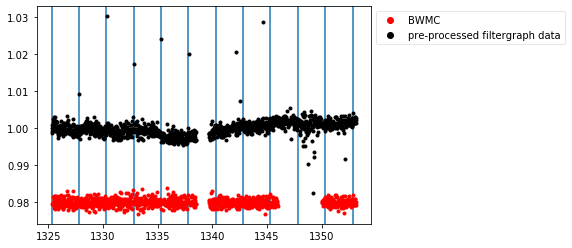

In [110]:
#momentum dumps:
mdumps=2.5 #for sector 1
Num_mdumps = int(np.round((time[-1]-time[0])/mdumps,2))+1
spacing=0.01
for x in range(Num_mdumps):
    plt.axvline(time[0]+2.5*x)    
# plt.plot(t3,f3-4*spacing,'g.',label="SG") #optional, see note in previous cell
# plt.plot(t2,f2-3*spacing,'b.',label="GP") #optional , see note in previous cell
plt.plot(t1,f1-2*spacing,'r.',label="BWMC")

plt.plot(time,flux,'k.',label='pre-processed filtergraph data')
plt.legend(loc='best',bbox_to_anchor=(1,1),fancybox=True,framealpha=0.5,markerscale=2)
plt.show()

# Now Let's do TLS with tweakable parameters

In [111]:
#TLS Parameters
minP=1.01
minDur= 1.0/24.0; maxDur= 5.0/24.0
N_transits = 2

Method 1: BWMC
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 130 durations
Searching 1037 data points, 4503 periods from 1.01 to 13.875 days
Using all 4 CPU threads


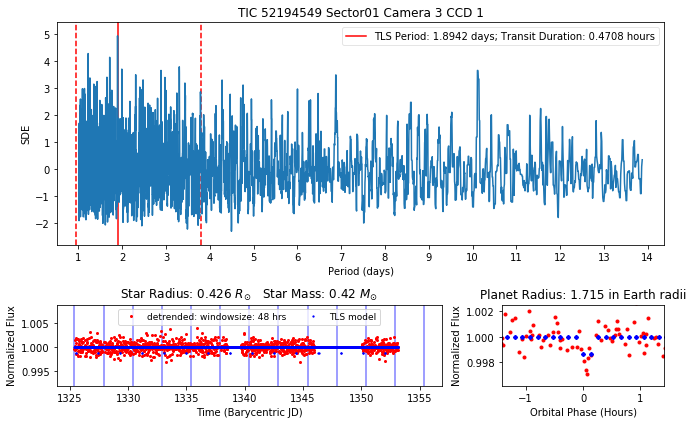

In [112]:

print("Method 1: BWMC")
tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_SDE, TLS_Dur,TLS_TCs, R_p, TLS_model_time, TLS_model,R_star,M_star = TLS_func(ID,t1,f1,e1,minP,minDur,maxDur,N_transits) 

TLS_plot(t1,f1,e1, tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_Dur, R_p, \
         TLS_model_time, TLS_model,window_size=2,R_star=R_star,M_star=M_star,mdumps=2.5)

# OPTIONAL

# print("Method 2: GP")
# tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_SDE, TLS_Dur, R_p, TLS_model_time, TLS_model = TLS_func(ID,t2,f2,e2,minP,minDur,maxDur,N_transits) 
# TLS_plot(t2,f2,e2, tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_Dur, R_p, \
#          TLS_model_time, TLS_model,window_size=2,R_star=R_star,M_star=M_star,mdumps=2.5)


# print("Method 3: SG")
# tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_SDE, TLS_Dur, R_p, TLS_model_time, TLS_model = TLS_func(ID,t3,f3,e3,minP,minDur,maxDur,N_transits) 
# TLS_plot(t3,f3,e3, tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_Dur, R_p, \
#         TLS_model_time, TLS_model,window_size=2,R_star=R_star,M_star=M_star,mdumps=3.1) #<-- check this mdump rate

x 12
trel: 0.1097008448455199
x 12
compared with full result
0.020833333333333332
0.020833333333333332


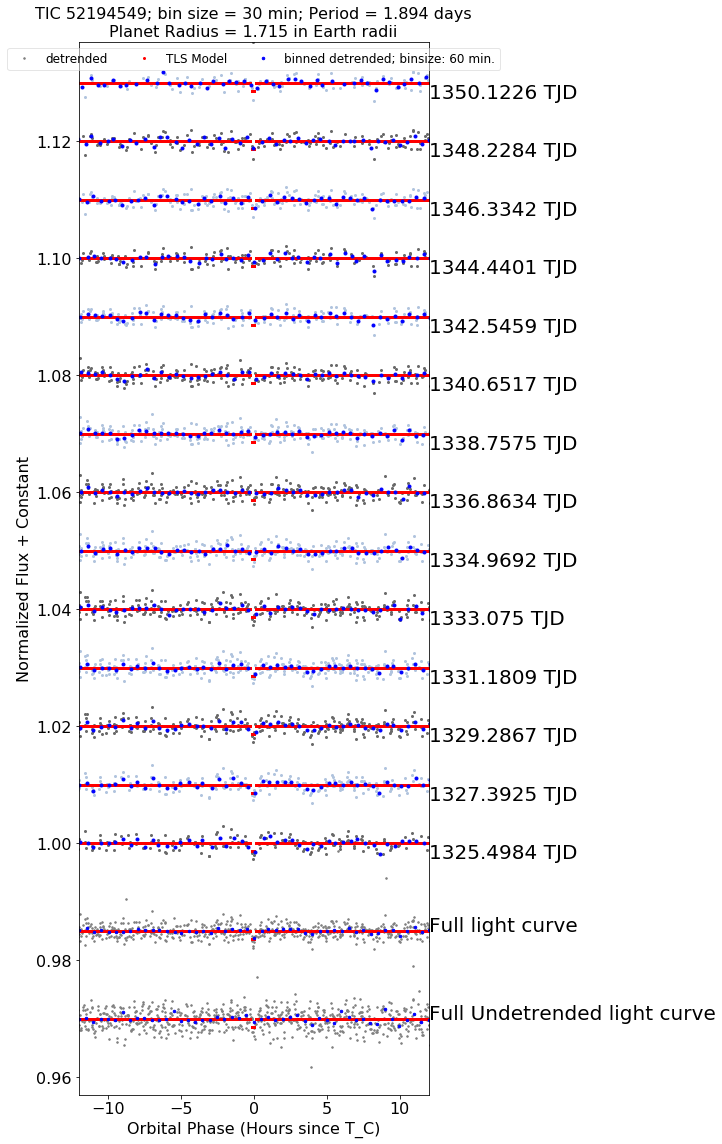

In [113]:
# Let's see what each modeled transit event looks like


plt.figure(figsize=(10,16))

ymin,ymax =phasematch_and_seperate_plot_TLS(ID,R_p,t1,f1,e1,TLS_TCs,TLS_t0s,TLS_model,TLS_model_time,TLS_periods,
                                 xwidth=12,spacing=0.01,window_size=6,bin_size_minutes=30,mdumps=2.5,
                                T_C_x_position=12,T_C_y_position=0.00)

#T_C_x_position and T_C_y_position control where the text appears for time stamps of "transit events"
# spacing controls how vertically separated each line is
# xwidth controls how wide each plot is (0 +/- width hours)

print("compared with full result")
p = TLS_periods
x_fold = (t1 - TLS_t0s + 0.5*p) % p - 0.5*p
pf_model = phasefold(TLS_t0s,TLS_model_time,p)

yyyy = 0.01*1.5 #vertical spacing 

plt.plot(24*x_fold,f1-yyyy,c='grey',markersize=3,marker='.',linestyle='none',zorder=1,label='detrended')#+", binsize: "+str(bin_size))
binsize = (30.0/(60*24)); print( binsize)
pf,ff,fefe = Bin_func(x_fold,f1,e1,binsize)
plt.plot(24*pf_model,TLS_model-yyyy,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='TLS Model')        
plt.plot(24*pf,ff-yyyy,c='blue',markersize=5,marker='.',linestyle='none',zorder=1,label='binned detrended; binsize: '+str(60)+' min.')    

plt.annotate("Full light curve", xy=( 12, np.mean(TLS_model-yyyy) ), xycoords='data', fontsize=16+4)



p = TLS_periods
x_fold = (time - TLS_t0s + 0.5*p) % p - 0.5*p
pf_model = phasefold(TLS_t0s,TLS_model_time,p)

yyyy = yyyy*2 #vertical spacing 

plt.plot(24*x_fold,flux-yyyy,c='grey',markersize=3,marker='.',linestyle='none',zorder=1)#,label='detrended')#+", binsize: "+str(bin_size))
binsize = (30.0/(60*24)); print( binsize)
pf,ff,fefe = Bin_func(x_fold,flux,fluxerror,binsize)
plt.plot(24*pf_model,TLS_model-yyyy,c='red',markersize=4,marker='.',linestyle='none',zorder=1)#,label='TLS Model')        
plt.plot(24*pf,ff-yyyy,c='blue',markersize=5,marker='.',linestyle='none',zorder=1)#,label='binned detrended; binsize: '+str(60)+' min.')    

plt.annotate("Full Undetrended light curve", xy=( 12, np.mean(TLS_model-yyyy) ), xycoords='data', fontsize=16+4)

plt.ylim(ymin-yyyy,ymax-0.5*yyyy)

# plt.ylim(0.985,1.041)
plt.tight_layout()

plt.legend(loc='upper center',fancybox=True,framealpha=0.5,ncol=3,fontsize=12)
plt.show()


# Note the binned blue points don't really fit the TLS model in the detrended data. There are really only two binned data points (TJD 1352 and 1338) that contribute to the "transit event"

# Let's compare with the original TLS pipeline result: 

original TLS pipeline plot:
 
LS period:  0.6138944717558491
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 131 durations
Searching 1082 data points, 4303 periods from 1.1 to 13.917 days
Using all 4 CPU threads
 
TIC  52194549   1   3   Sector01
best period:  12.029469785565933
best T0:  1330.24478961815


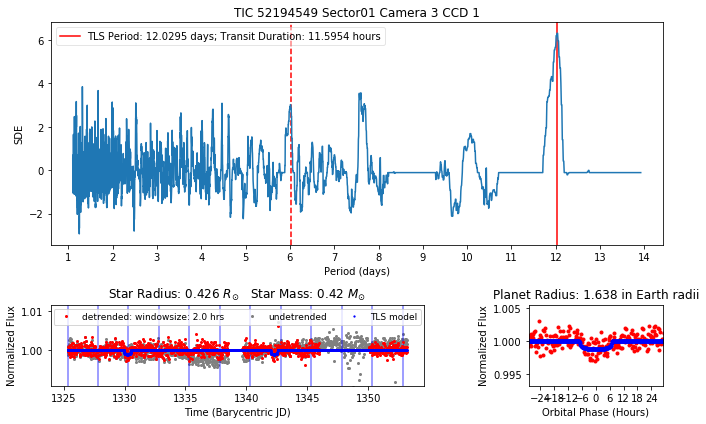

In [114]:
print("original TLS pipeline plot:" )

mask = np.where(np.isfinite(flux)==True)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
time2 = time[mask]                        #Sometimes there are holes in data filled with NaNs
flux2 = flux[mask]
fluxerror2 = fluxerror[mask]


#known bad data points with high telescope jitter:
SectorNum = int((os.path.basename(match).split)('_')[1][6:])
if SectorNum==1:
    jittermask = (time2 < 1346) | (time2 > 1350)
    mdumps=2.5


    t1,f1,fe1 = time2[jittermask], flux2[jittermask], fluxerror2[jittermask]

    t2,f2,fe2=t1,f1,fe1
else:

    t2,f2,fe2=time2,flux2,fluxerror2

if SectorNum==3:
    jittermask = (time2 < 1382.6) | (time2 > 1383.65)
    mdumps=3.125

    t1,f1,fe1 = time2[jittermask], flux2[jittermask], fluxerror2[jittermask]

    t2,f2,fe2=t1,f1,fe1

if SectorNum==2:
    mdumps=2.5
    t2,f2,fe2=time2,flux2,fluxerror2     
    
    
    
#check for rapid rotators with Lomb-Scargle (P_rot < 3 days)
period = 10 ** np.linspace(np.log10(0.1), np.log10(3), 1000)
#     period = 10 ** np.linspace(np.log10(0.1), np.log10(80), 1000)
freq = 2.0 * np.pi / period
PS = lomb_scargle(t2,f2,fe2,omega=freq, generalized=True)
Standpower = (PS-np.mean(PS))/np.std(PS)
print(" ")    
print("LS period: ",period[np.argmax(Standpower)])

if period[np.argmax(Standpower)] < 3:

    print("Applying Quasi Periodic GP...")
    length_scale=2 # 1 to 2 is generally pretty good from my tests
    gpflatten_lc, gptrend_lc = flatten(t2,f2,method='gp', \
                                         kernel='periodic_auto',kernel_size=length_scale,return_trend=True,robust=True)

    T=t2
    F= gpflatten_lc
    FE = fe2
    
    T,F,FE = ChauventsCriteron(T,F,FE)
    flatten_lc, trend_lc = flatten(T,F,method='savgol',window_length=241,cval=3,return_trend=True)


    nanmask = np.where(np.isfinite(flatten_lc)==True)[0]
    T = T[nanmask]
    F = flatten_lc[nanmask]/np.mean(flatten_lc[nanmask])
    FE =FE[nanmask]

    window_size_wotan = length_scale/24.0
else:

    print("Applying Biweighted Midcorrelation Function...")
    window_size_wotan = 5.0/24.0 # The length of the filter window in units of time (days)
    flatten_lc, trend_lc = flatten(t2, f2, window_length=window_size_wotan, return_trend=True, break_tolerance=window_size_wotan/2.0,method='biweight',robust=True)
    T=t2
    F=flatten_lc
    FE=fe2

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]

    T,F,FE = ChauventsCriteron(T,F,FE)

#checking for NaNs
nanmask = np.where(np.isfinite(F)==True)[0]
T = T[nanmask]
F = F[nanmask]
FE =FE[nanmask]

qld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)
spacing = 0.02

SDE_threshold=6.0 #we've been testing different values here (6,6.5,7). For now, let's try sticking with 6.
 
fs = 9

#for reporting TLS model's planet radius
R_earth = 6.378*10.0**8.0 #cm
R_sun = 6.955*10.0**10.0 #cm

if np.isfinite(R_star)==True and np.isfinite(M_star)==True: #checks to see if stellar information is unknown in MAST catalogs
    minP=1.1
    maxP= (max(T)-min(T)) #length of our light curve
    minDur = 1.0/24.0
    maxDur = 5.0/24.0

    #creating list of orbital periods to model with
    periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP/3.0)#,oversampling_factor=10)

    durations = np.linspace(minDur,maxDur,25)

    tls = transitleastsquares(T,F,FE)
    tls_power = tls.power(R_star=R_star,period_min=minP,period_max=maxP,show_progress_bar=False,n_transits_min=2,duration_grid_step=1.02)

    #TLS results
    TLS_periods=tls_power.period
    TLS_t0s=tls_power.T0
    TLS_depths=tls_power.depth
    TLS_SDE=tls_power.power
    TLS_Dur = tls_power.duration
    TLS_TCs = tls_power.transit_times
    
    #calculating TLS estimated planet radius
    R_p = np.sqrt(1-TLS_depths)*R_star*R_sun/R_earth

    #creating the best fit box model to our data
    TLS_model_time = tls_power.model_lightcurve_time 
    TLS_model = tls_power.model_lightcurve_model 

    p = TLS_periods
    pf_model = (TLS_model_time - TLS_t0s + 0.5*p) % p - 0.5*p        
    x_fold = (T - TLS_t0s + 0.5*p) % p - 0.5*p
#     x_fold_raw = (t - TLS_t0s + 0.5*p) % p - 0.5*p

    detrendedphasefoldedlc = [x_fold, F, FE]
#     phasefoldedlc = [x_fold_raw, f, fe]


#     if len(np.where(TLS_SDE>SDE_threshold)[0])>0:
    print(" ")
    print("TIC ", str(ID), " ",CCD, " ",Camera, " ",Sector)
    print("best period: ", TLS_periods)
    print("best T0: ",TLS_t0s)

    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(gs1[:-1, :])
    ax2 = fig.add_subplot(gs1[-1, :-1])
    ax3 = fig.add_subplot(gs1[-1, -1])


    ax1.axvline(x=TLS_periods,color='r',label='TLS Period: '+str( np.round(TLS_periods,4) )+" days; Transit Duration: "+str(np.round(24*TLS_Dur,4))+" hours") #rounding period to 4 decimal places 
    ax1.axvline(x=0.5*TLS_periods,color='r',linestyle='--')
    ax1.axvline(x=2.0*TLS_periods,color='r',linestyle='--') 
    ax1.plot(tls_power.periods, TLS_SDE, rasterized=True)
    plt.xticks(np.arange(0.0, 31.0, 1.0))
    ax1.set_title("TIC "+str(ID)+" "+Sector+" Camera "+Camera+" CCD "+CCD)
    ax1.set_xlabel("Period (days)")
    ax1.set_xticks(np.arange(1.0, 15.0, 1.0))
    ax1.set_xlim(np.min(tls_power.periods)-0.5, np.max(tls_power.periods)+0.5)

    ax1.set_ylabel("SDE")
    ax1.set_ylim(np.min(TLS_SDE)-0.5, np.max(TLS_SDE)+0.5)
    ax1.legend(loc='best',fancybox=True,framealpha=0.5)

    ax2.plot(T, F ,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24)+' hrs')#+", binsize: "+str(bin_size)) 
    ax2.plot(time,flux,c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
    ax2.plot(TLS_model_time,TLS_model,'b.',label='TLS model',markersize=2.5)
    ax2.legend(loc='upper center',ncol=3,fontsize=fs)
    ax2.set_ylim(np.min(F)-5*np.std(F), np.max(F)+5*np.std(F))
    for x in range(12):
        ax2.axvline(x=(T[0]+x*mdumps),color='b',alpha=0.5,zorder=0)
    ax2.set_title("Star Radius: "+str(np.round(R_star,3))+r" $R_{\odot}$   Star Mass: "+str(np.round(M_star,3))+r" $M_{\odot}$")

    ax2.set_xlabel("Time (Barycentric JD)")
    ax2.set_ylabel("Normalized Flux") 

    ax3.plot(24*x_fold,detrendedphasefoldedlc[1],c='red',markersize=6,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24)+' hrs')
    ax3.plot(24*pf_model,TLS_model,'b.',label='TLS model',markersize=5)
    ax3.set_xlabel("Orbital Phase (Hours)")
    ax3.set_ylabel("Normalized Flux") 
    ax3.set_title("Planet Radius: "+str(np.round(R_p,3))+" in Earth radii")
    ax3.set_ylim(np.min(TLS_model)-25*np.std(TLS_model), np.max(TLS_model)+25*np.std(TLS_model))
    ax3.set_xticks(np.arange(np.round(-7*TLS_Dur*24.0),np.round(7*TLS_Dur*24.0),2)) #hours

    if TLS_Dur*24> 8.0:
        ax3.set_xticks(np.arange(np.round(-14*TLS_Dur*24.0),np.round(14*TLS_Dur*24.0),6)) #hours
        ax3.set_xlim(-2.5*TLS_Dur*24,2.5*TLS_Dur*24)

    else:
#                     TLS_Dur*24< 1.0 and TLS_Dur*24< 8.0:
        ax3.set_xticks(np.arange(np.round(-7*TLS_Dur*24.0),np.round(7*TLS_Dur*24.0),2)) #hours
        ax3.set_xlim(-5,5)

    if TLS_Dur*24< 1.0:
        ax3.set_xticks(np.arange(np.round(-15*TLS_Dur*24.0),np.round(15*TLS_Dur*24.0),1.)) #hours
        ax3.set_xlim(-3*TLS_Dur*24,3*TLS_Dur*24)

    gs1.tight_layout(fig)

#             plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_TLS.png")
    plt.show()    


# With the momentum dumps removed and re-detrended, this initial "detection" is no more. Let's look at each modeled transit event separated and compare it to the undetrended data:

x 24
trel: 4.918617618149938
x 24
compared with full result
0.020833333333333332
0.020833333333333332


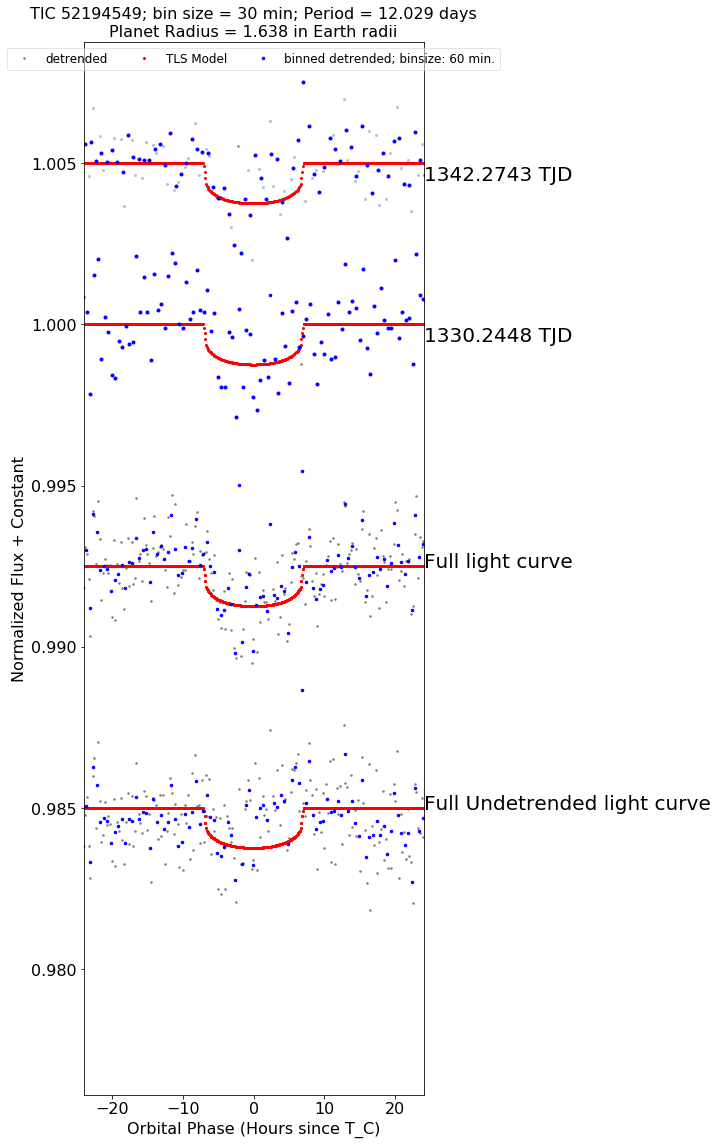

In [115]:
# Let's see what each modeled transit event looks like


plt.figure(figsize=(10,16))
T_C_x_position =24
ymin,ymax = phasematch_and_seperate_plot_TLS(ID,R_p,T,F,FE,TLS_TCs,TLS_t0s,TLS_model,TLS_model_time,TLS_periods,
                                 xwidth=24,spacing=0.005,window_size=6,bin_size_minutes=30,mdumps=2.5,
                                T_C_x_position=T_C_x_position,T_C_y_position=0.00)

#T_C_x_position and T_C_y_position control where the text appears for time stamps of "transit events"
# spacing controls how vertically separated each line is
# xwidth controls how wide each plot is (0 +/- width hours)

print("compared with full result")
p = TLS_periods
x_fold = (T - TLS_t0s + 0.5*p) % p - 0.5*p
pf_model = phasefold(TLS_t0s,TLS_model_time,p)

yyyy = 0.005*1.5 #vertical spacing 

plt.plot(24*x_fold,F-yyyy,c='grey',markersize=3,marker='.',linestyle='none',zorder=1,label='detrended')#+", binsize: "+str(bin_size))
binsize = (30.0/(60*24)); print( binsize)
pf,ff,fefe = Bin_func(x_fold,F,FE,binsize)
plt.plot(24*pf_model,TLS_model-yyyy,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='TLS Model')        
plt.plot(24*pf,ff-yyyy,c='blue',markersize=5,marker='.',linestyle='none',zorder=1,label='binned detrended; binsize: '+str(60)+' min.')    

plt.annotate("Full light curve", xy=( T_C_x_position, np.mean(TLS_model-yyyy) ), xycoords='data', fontsize=16+4)



p = TLS_periods
x_fold = (time - TLS_t0s + 0.5*p) % p - 0.5*p
pf_model = phasefold(TLS_t0s,TLS_model_time,p)

yyyy = yyyy*2 #vertical spacing 

plt.plot(24*x_fold,flux-yyyy,c='grey',markersize=3,marker='.',linestyle='none',zorder=1)#,label='detrended')#+", binsize: "+str(bin_size))
binsize = (30.0/(60*24)); print( binsize)
pf,ff,fefe = Bin_func(x_fold,flux,fluxerror,binsize)
plt.plot(24*pf_model,TLS_model-yyyy,c='red',markersize=4,marker='.',linestyle='none',zorder=1)#,label='TLS Model')        
plt.plot(24*pf,ff-yyyy,c='blue',markersize=5,marker='.',linestyle='none',zorder=1)#,label='binned detrended; binsize: '+str(60)+' min.')    

plt.annotate("Full Undetrended light curve", xy=( T_C_x_position, np.mean(TLS_model-yyyy) ), xycoords='data', fontsize=16+4)


plt.ylim(ymin-yyyy,ymax-0.5*yyyy)
# plt.xlim(-50,50)
plt.tight_layout()

plt.legend(loc='upper center',fancybox=True,framealpha=0.5,ncol=3,fontsize=12)
plt.show()


# We can see this event is created in the detrending process with what looks like a small flare. Let's try tweaking detrending for future cases

In [116]:
print(ymin,ymax)

0.991100175089611 1.0162704438731547


In [117]:
# %reset -sf

In [118]:
# This particular TIC ID (52194549) is a TOI